# 2. Subcluster Leiden Cluster 1

This script loads the full dataset, subsets it to cells in Leiden cluster 1,
and then re-runs dimensionality reduction and clustering to find sub-populations.

In [1]:
import scanpy as sc
import os
import sys
import anndata as ad
from pathlib import Path

In [2]:
# --- Configuration ---
PROJECT_DIR = "D:/Github/SRF_Linda_RNA"
WORKING_DIR = os.path.join(PROJECT_DIR, "combine_data")
os.chdir(WORKING_DIR)
sys.path.insert(0, WORKING_DIR)

# Define Input Directory for Processed Data
INPUT_DIR = os.path.join(WORKING_DIR, "results_from_raw")
input_file = os.path.join(INPUT_DIR, 'merged_raw_processed.h5ad')

# Define Output Directory for this analysis
OUTPUT_DIR = os.path.join(WORKING_DIR, "results_subclustering")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define Cluster to Subcluster
CLUSTER_ID = '1'
LEIDEN_RESOLUTION_KEY = 'leiden_0.4' # The key from the initial clustering

# Define Subclustering Parameters
N_PCS = 30 # Number of PCs to use for subclustering
SUBCLUSTER_RESOLUTION = 0.2 # Resolution for sub-clustering

output_file_subcluster = os.path.join(OUTPUT_DIR, f'subcluster_{CLUSTER_ID}_processed.h5ad')

## Load Full Dataset

In [3]:
print(f"Loading full dataset from {input_file}...")
if not os.path.exists(input_file):
    print(f"Error: Input file not found at {input_file}")
    sys.exit(1)

adata_full = ad.read_h5ad(input_file)
print("Full dataset loaded:")
print(adata_full)

Loading full dataset from D:/Github/SRF_Linda_RNA\combine_data\results_from_raw\merged_raw_processed.h5ad...
Full dataset loaded:
AnnData object with n_obs × n_vars = 28026 × 26881
    obs: 'sample', 'condition', 'genotype', 'sample_batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_0.4'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'condition_colors', 'genotype_colors', 'hvg', 'leiden_0.4', 'leiden_0.4_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


## Subset to Cluster

In [4]:
print(f"Subsetting data to cluster '{CLUSTER_ID}' from '{LEIDEN_RESOLUTION_KEY}'...")

# Ensure the leiden column is treated as categorical
if LEIDEN_RESOLUTION_KEY in adata_full.obs:
    adata_full.obs[LEIDEN_RESOLUTION_KEY] = adata_full.obs[LEIDEN_RESOLUTION_KEY].astype('category')
else:
    print(f"Error: Leiden key '{LEIDEN_RESOLUTION_KEY}' not found in adata.obs")
    sys.exit(1)

# Subset the anndata object
adata_sub = adata_full[adata_full.obs[LEIDEN_RESOLUTION_KEY] == CLUSTER_ID].copy()

print(f"Subset created with {adata_sub.n_obs} cells.")

Subsetting data to cluster '1' from 'leiden_0.4'...
Subset created with 3607 cells.


## Re-run Analysis on Subset

In [5]:
print("\nRe-running analysis on the subset...")

# It's often a good practice to re-identify highly variable genes on the subset
print("Finding highly variable genes on the subset...")
# Using 'cell_ranger' flavor as 'seurat_v3' can cause errors on subsets.
sc.pp.highly_variable_genes(adata_sub, n_top_genes=3000, flavor='cell_ranger')

# Re-run PCA
print(f"Running PCA using {adata_sub.n_vars} genes...")
sc.tl.pca(adata_sub, n_comps=50, use_highly_variable=True, svd_solver='arpack')

# Re-compute neighborhood graph
print(f"Computing neighborhood graph using {N_PCS} PCs...")
sc.pp.neighbors(adata_sub, n_neighbors=15, n_pcs=N_PCS)

# Re-run UMAP
print("Running UMAP...")
sc.tl.umap(adata_sub)

# Re-run Leiden for subclustering
print(f"Running Leiden clustering with resolution {SUBCLUSTER_RESOLUTION}...")
sc.tl.leiden(adata_sub, resolution=SUBCLUSTER_RESOLUTION, key_added=f'leiden_sub_{CLUSTER_ID}')

print("Sub-analysis complete.")


Re-running analysis on the subset...
Finding highly variable genes on the subset...
Running PCA using 26881 genes...


d:\Programs\miniforge3\envs\bioinf\Lib\site-packages\scanpy\preprocessing\_pca\__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)


Computing neighborhood graph using 30 PCs...


d:\Programs\miniforge3\envs\bioinf\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running UMAP...
Running Leiden clustering with resolution 0.2...
Sub-analysis complete.


C:\Users\janku\AppData\Local\Temp\ipykernel_57044\925284716.py:22: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_sub, resolution=SUBCLUSTER_RESOLUTION, key_added=f'leiden_sub_{CLUSTER_ID}')


## Visualization


Generating visualizations for subclusters...


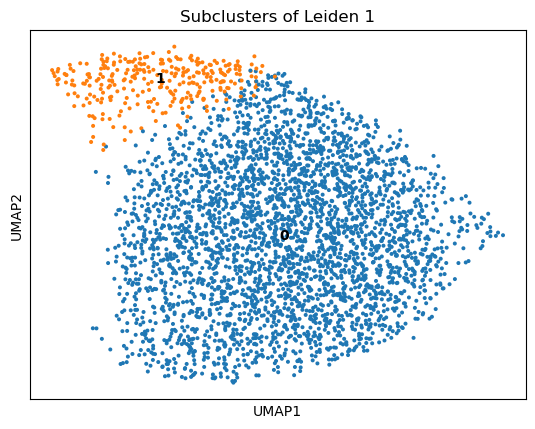

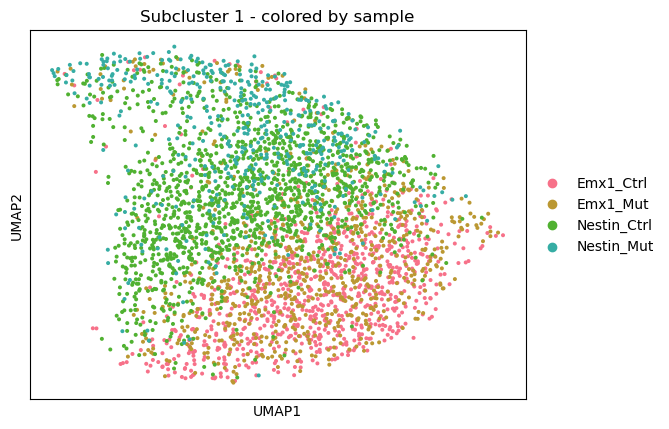

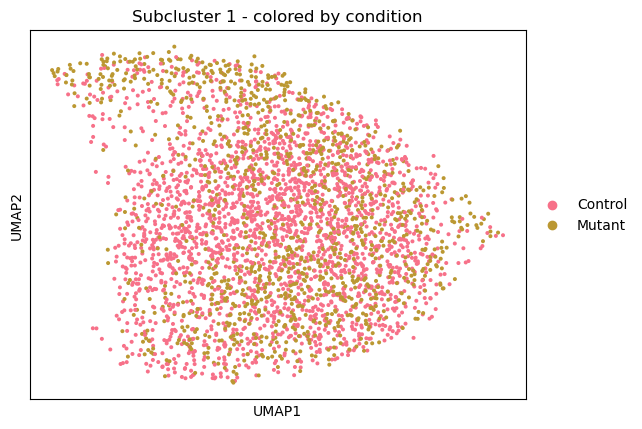

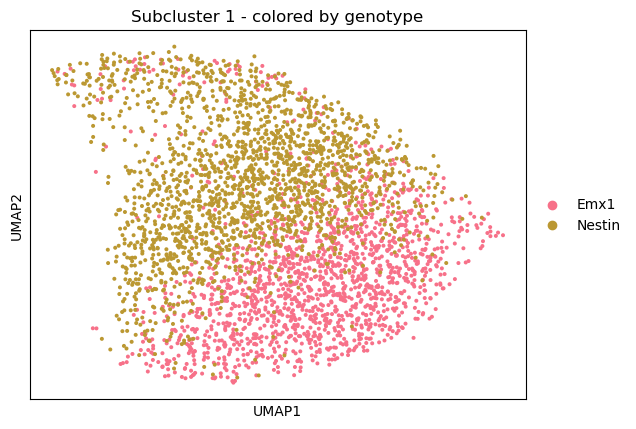

In [6]:
print("\nGenerating visualizations for subclusters...")

# Create directory for plots if it doesn't exist
plot_dir = os.path.join(OUTPUT_DIR, "plots_subclustering")
os.makedirs(plot_dir, exist_ok=True)
sc.settings.figdir = plot_dir

# Plot UMAP colored by the new subclusters
sc.pl.umap(adata_sub, color=f'leiden_sub_{CLUSTER_ID}', legend_loc='on data',
           save=f"_umap_subcluster_{CLUSTER_ID}.png", show=True,
           title=f'Subclusters of Leiden {CLUSTER_ID}')

# Plot UMAP colored by original metadata to see if there's a pattern
for col in ['sample', 'condition', 'genotype']:
    if col in adata_sub.obs:
        sc.pl.umap(adata_sub, color=col,
                   save=f"_umap_subcluster_{CLUSTER_ID}_{col}.png", show=True,
                   title=f'Subcluster {CLUSTER_ID} - colored by {col}')

## Save Subclustered Data

In [7]:
print(f"\nSaving subclustered dataset to {output_file_subcluster}")
try:
    adata_sub.write(Path(output_file_subcluster))
    print("Successfully saved the subclustered AnnData object.")
except Exception as e:
    print(f"Error saving AnnData object: {e}")

print("\nScript finished!")


Saving subclustered dataset to D:/Github/SRF_Linda_RNA\combine_data\results_subclustering\subcluster_1_processed.h5ad
Successfully saved the subclustered AnnData object.

Script finished!
